# Quantifying Scaling Accuracy 1

**Summary**: This notebook seeks to get a handle on the accuracy of our likelihood calculation, specifically how this accuracy scales as we increase the number of halos.

[Motivation](https://github.com/davidthomas5412/PanglossNotebooks/blob/master/MassLuminosityProject/Worrisome_20170417.ipynb)

Code copied from 'SingleIntegralComparison4_2017_03_29.ipynb':

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
import seaborn.apionly as sns
from scipy.optimize import minimize
from math import sqrt
from time import time
rc('text', usetex=True)
from matplotlib.patches import Ellipse

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')

prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def logp1(lobs, lum, sigma):
    return fast_log_lognormal(lum, sigma, lobs)

def logp2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_log_lognormal(mu_lum, S, lum)

def logp3(mass, z):
    return prior.fetch(z).logpdf(mass)

def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

def fast_log_lognormal(mu, sigma, x):
    return  -np.log(x * sigma * np.sqrt(2 * np.pi)) - 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2

def log10(arr):
    return np.log(arr) / np.log(10)

def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

a1,a2,a3,a4,S = get()
sigma = 0.05

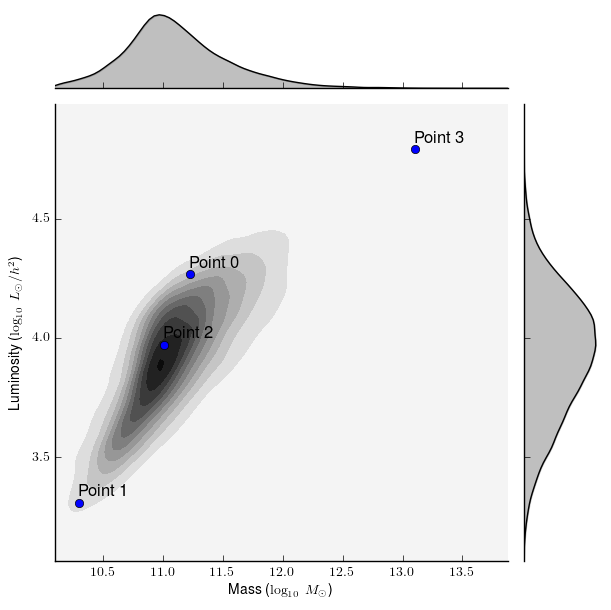

In [3]:
dat = np.array([np.arange(len(data.mass)), log10(data.mass), log10(data.lum)]).transpose()
datr = np.random.permutation(dat)

inds = [115916, 103133, 79417, 13008]

ax = sns.jointplot(x=datr[:30000,1], y=datr[:30000,2], kind="kde", color='black');
for i,ind in enumerate(inds):
    ax.ax_joint.plot(dat[ind,1], dat[ind,2], marker='o', color='blue')
    ax.ax_joint.text(dat[ind,1], dat[ind,2]+0.03, "Point %d" % i, ha ='left', fontsize = 12, color='black')
ax.ax_joint.legend_.remove()
ax.ax_joint.set_ylabel('Luminosity ($\log_{10}\ L_{\odot} / h^2$)')
ax.ax_joint.set_xlabel('Mass ($\log_{10}\ M_{\odot}$)')
xlim = (datr[:30000, 1].min(), datr[:30000, 1].max())
ylim = (datr[:30000, 2].min(), datr[:30000, 2].max())
ax.ax_joint.set_xlim(xlim)
ax.ax_joint.set_ylim(ylim);

### Numerical Integration

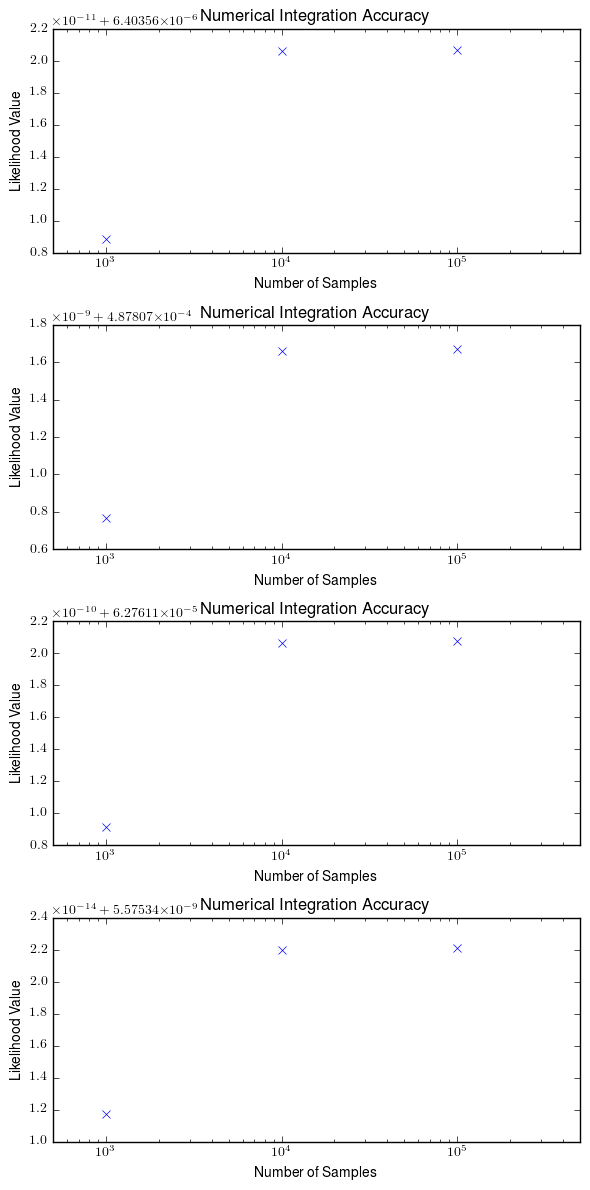

In [54]:
nsamples = np.logspace(3,5,3)
    
for i,idx in enumerate(inds):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs
    vals = map(lambda x: numerical_integration(a1, a2, a3, a4, S, x), nsamples)
    
    plt.subplot(4,1,i+1)
    plt.plot(nsamples, vals, 'x')
    plt.gca().set_xscale('log')
    plt.xlim(5*10**2,5*10**5)
    plt.xlabel('Number of Samples')
    plt.ylabel('Likelihood Value')
    plt.title('Numerical Integration Precision')

plt.gcf().set_size_inches(6,12)
plt.tight_layout()

We conclude that numerical integration is extremely accurate and that $10^5$ samples gives us 7-8 digits of precision (where we assume that computational error is monotonically decreasing with number of samples).

### Importance Sampling

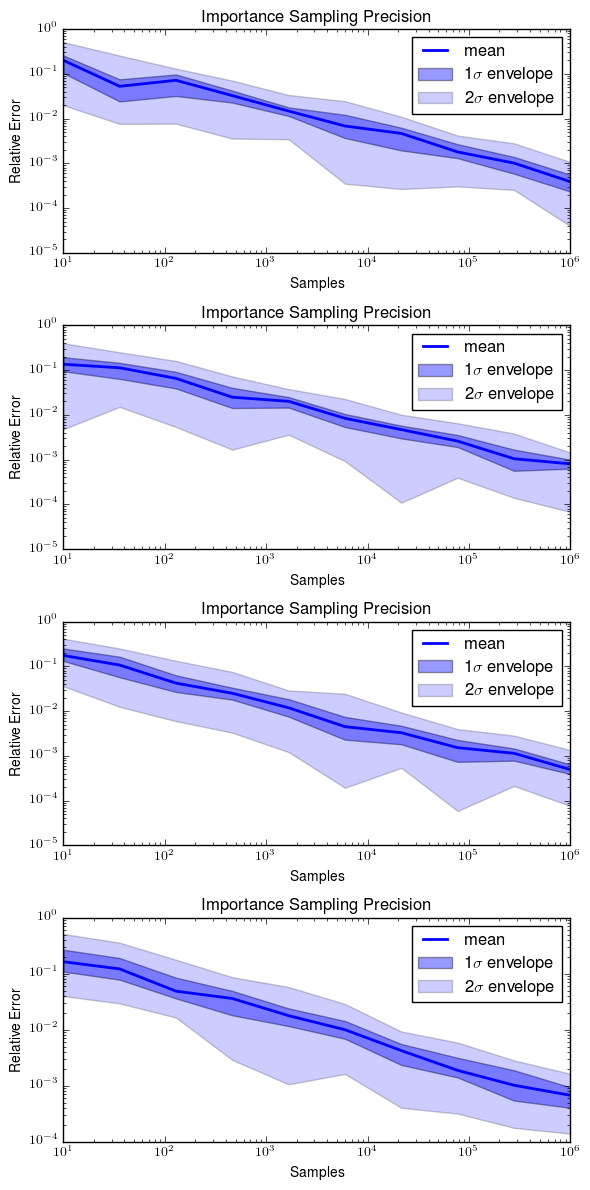

In [86]:
space = np.logspace(1,6,10)
samples = 40
subplot = 1

for idx in inds:
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs
    ans = numerical_integration(a1,a2,a3,a4,S, nsamples=10**5)
    rel_error = np.zeros((len(space), samples))
    for i,s in enumerate(space): 
        for samp in xrange(samples):
            rel_error[i,samp] = (abs(importance_sampling_integration(a1,a2,a3,a4,S, nsamples=int(s)) - ans) / ans)
    shi = map(lambda x: np.percentile(x, 95), rel_error)
    hi = map(lambda x: np.percentile(x, 68), rel_error)
    mean = map(lambda x: np.percentile(x, 50), rel_error)
    lo = map(lambda x: np.percentile(x, 32), rel_error)
    slo = map(lambda x: np.percentile(x, 5), rel_error)
    
    plt.subplot(4,1,subplot)
    plt.plot(space, mean, linewidth=2, label='mean')
    plt.fill_between(space, lo, hi, alpha=0.4, label='1$\sigma$ envelope')
    plt.fill_between(space, slo, shi, alpha=0.2, label='2$\sigma$ envelope')
    plt.gca().set_yscale('log')
    plt.gca().set_xscale('log')
    plt.title('Importance Sampling Precision')
    plt.ylabel('Relative Error')
    plt.xlabel('Samples')
    plt.legend()
    subplot += 1

plt.gcf().set_size_inches(6,12)
plt.tight_layout()

The relative error decreases linearly with the number of samples. These plots also suggest that relative error is independent of the particular halo, which will make modelling it a bit easier. **Key Assumption 1:** will assume the relative error for a particular halo's likelihood integral is independent, identically distributed log-normal.

### Modelling Error Accumulation

True weights of the four points above:

In [89]:
for i,idx in enumerate(inds):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs
    print numerical_integration(a1, a2, a3, a4, S, 10**4)

6.40358058377e-06
0.000487808661776
6.27613065943e-05
5.57536196939e-09


Unfortunately while the relative error in importance sampling seems iid, the weights can very dramatically and we will need to incorporate this into our model somehow. I suspect that much of this weight disparity can be explained from the mass prior. **Key Assumption 2:** I am going to use the variation in the mass prior probabilities for the true masses to approximately model the variation in weights of the single halo likelihoods. 

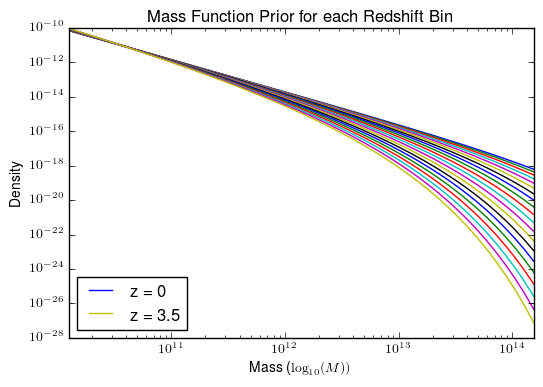

In [90]:
space = np.logspace(log10(prior.min_mass), log10(prior.max_mass))
for rs in prior.grid.redshifts:
    pdf = prior.fetch(rs).pdf(space)
    if rs == 0:
        plt.plot(space, pdf, label='z = 0')
    elif rs == 3.5:
        plt.plot(space, pdf, label='z = 3.5')
    else:
        plt.plot(space, pdf)
plt.legend(loc=3)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim([prior.min_mass, prior.max_mass])
plt.title('Mass Function Prior for each Redshift Bin')
plt.xlabel('Mass ($\log_{10}(M))$')
plt.ylabel('Density')

The computatation we make is of the form 

$$\prod_{i=1}^{n} \left[\iint f(\alpha,S,L_i,M_i,z_i)\ dL_i\ dM_i\right] \approx \prod_{i=1}^{n} w_i(1 + p_i)$$

where $n$ is the number of halos. We model this with the LHS where $w_i = P(M_i|z_i)$ and $p_i = \mathcal{N}(0, 0.05)$ [can be more rigorous with this fit in the future, currently just comparing output to 1 sigma band]. 

In [166]:
tot = 115919
w = np.zeros(tot)
mass = data.mass.as_matrix()
z = data.z.as_matrix()
for i in xrange(115919):
    w[i] = prior.pdf(mass[i], z[i])

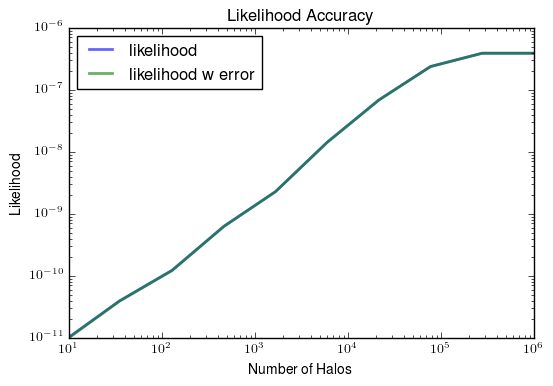

In [167]:
from scipy.stats import norm

p = norm(0, scale=0.05).rvs(size=tot)

space = map(lambda x : int(x), np.logspace(1,6,10))

ans_without_error = np.zeros(len(space))
ans_with_error = np.zeros(len(space))
steps = np.zeros(len(space))

for i,stop in enumerate(space):
    steps[i] = stop
    ans_without_error[i] = np.sum(w[:stop] * (1 + p[:stop]))
    ans_with_error[i] = np.sum(w[:stop])
    
plt.title('Likelihood Accuracy')
plt.xlabel('Number of Halos')
plt.ylabel('Likelihood')
plt.plot(steps, ans_with_error, label='likelihood',linewidth=2, alpha=0.6)
plt.plot(steps, ans_without_error, label='likelihood w error', linewidth=2,alpha=0.6)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc=2)

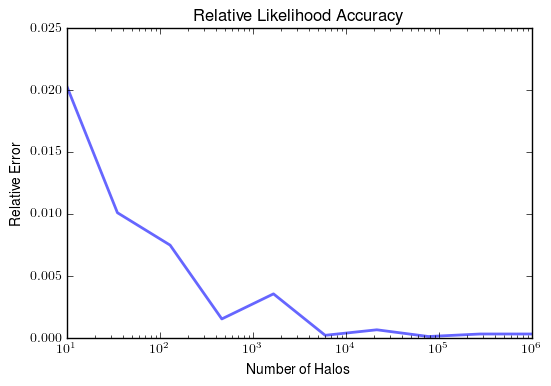

In [168]:
plt.title('Relative Likelihood Accuracy')
plt.xlabel('Number of Halos')
plt.ylabel('Relative Error')
plt.plot(steps, np.abs(ans_without_error- ans_with_error)/ ans_with_error, label='relative error',linewidth=2, alpha=0.6)
plt.gca().set_xscale('log')

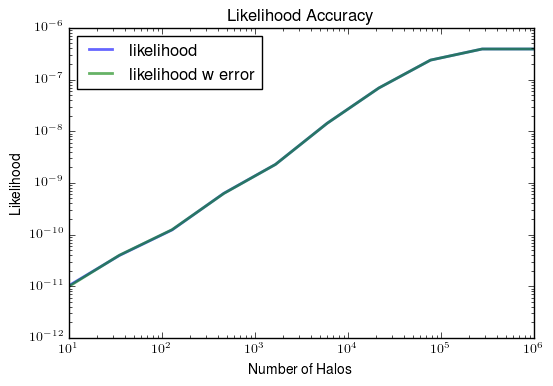

In [169]:
p = norm(0, scale=0.05).rvs(size=tot)

ans_without_error = np.zeros(len(space))
ans_with_error = np.zeros(len(space))
steps = np.zeros(len(space))

for i,stop in enumerate(space):
    steps[i] = stop
    ans_without_error[i] = np.sum(w[:stop] * (1 + p[:stop]))
    ans_with_error[i] = np.sum(w[:stop])
    
plt.title('Likelihood Accuracy')
plt.xlabel('Number of Halos')
plt.ylabel('Likelihood')
plt.plot(steps, ans_with_error, label='likelihood',linewidth=2, alpha=0.6)
plt.plot(steps, ans_without_error, label='likelihood w error', linewidth=2,alpha=0.6)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc=2)

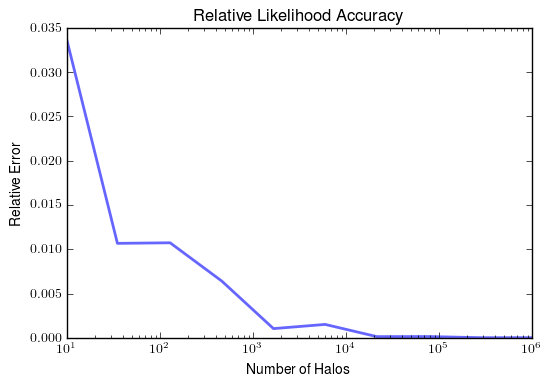

In [170]:
plt.title('Relative Likelihood Accuracy')
plt.xlabel('Number of Halos')
plt.ylabel('Relative Error')
plt.plot(steps, np.abs(ans_without_error- ans_with_error)/ ans_with_error, label='relative error',linewidth=2, alpha=0.6)
plt.gca().set_xscale('log')

This modelling suggests that accuracy should not be an issue.

- Need to examine likelihood accuracy for different hyperparameters (have been using true hyperparameters) - duh!
- Perhaps the poor convergence that caused us to worry in the first place can be explained by the mass prior. Should repeat original experiment [here](https://github.com/davidthomas5412/PanglossNotebooks/blob/master/MassLuminosityProject/Worrisome_20170417.ipynb) with masses drawn from the mass prior.
- Need to get distribution of individual halo single likelihood weights.